Błąd: Nie znaleziono pliku 'abalone.csv'.


C:\Users\rafal\PycharmProjects\smart-booking-system\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Najlepsza strata walidacyjna: 0.3779
Najlepsza dokładność walidacyjna: 0.8356


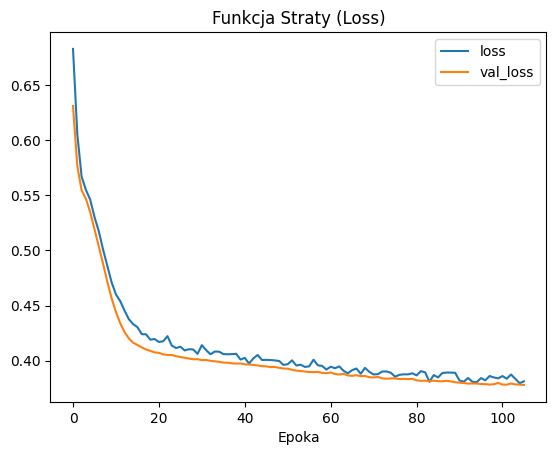

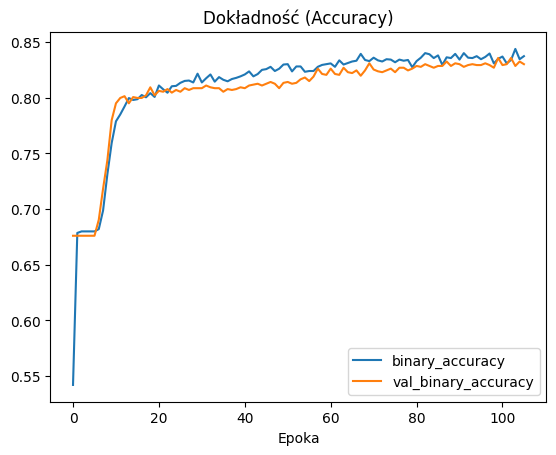

In [3]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- 1. Wczytanie i przygotowanie danych ---
# Upewnij się, że plik 'abalone.csv' jest w odpowiednim katalogu
try:
    df_raw = pd.read_csv('abalone.csv')
except FileNotFoundError:
    print("Błąd: Nie znaleziono pliku 'abalone.csv'.")
    exit()

# Kopiowanie danych do nowego DataFrame
df = df_raw.copy()

# Utworzenie binarnej zmiennej docelowej 'is_adult'
df['is_adult'] = df['Type'].map({'M': 1, 'F': 1, 'I': 0})
df = df.drop('Type', axis=1) # Usunięcie oryginalnej kolumny

# --- 2. Podział na zbiór treningowy i walidacyjny ---
df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

# --- 3. Normalizacja danych ---
# Skalujemy dane do przedziału [0, 1] tak jak w tutorialu
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Przygotowanie finalnych zbiorów X i y
X_train = df_train.drop('is_adult', axis=1)
y_train = df_train['is_adult']
X_valid = df_valid.drop('is_adult', axis=1)
y_valid = df_valid['is_adult']

# Pobranie liczby cech dla warstwy wejściowej
input_shape = [X_train.shape[1]]

# --- 4. Budowa modelu sieci neuronowej ---
model = keras.Sequential([
    # Warstwa wejściowa z 128 neuronami i aktywacją relu
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3), # Warstwa dropout zapobiegająca przeuczeniu
    # Warstwa ukryta z 64 neuronami
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    # Warstwa wyjściowa z 1 neuronem i aktywacją sigmoid (dla klasyfikacji binarnej)
    layers.Dense(1, activation='sigmoid'),
])

# --- 5. Kompilacja modelu ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Funkcja straty dla klasyfikacji binarnej
    metrics=['binary_accuracy'], # Metryka do monitorowania
)

# --- 6. Trening modelu z Early Stopping ---
early_stopping = keras.callbacks.EarlyStopping(
    patience=10, # Liczba epok bez poprawy, po której trening zostanie przerwany
    min_delta=0.001, # Minimalna zmiana, aby uznać ją za poprawę
    restore_best_weights=True, # Przywrócenie wag modelu z najlepszej epoki
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000, # Ustawiamy dużą liczbę epok, EarlyStopping znajdzie najlepszy moment
    callbacks=[early_stopping],
    verbose=0, # Ukrycie logów z każdej epoki
)

# --- 7. Wizualizacja i ocena wyników ---
history_df = pd.DataFrame(history.history)

# Wykres funkcji straty
history_df.loc[:, ['loss', 'val_loss']].plot(title="Funkcja Straty (Loss)")
plt.xlabel("Epoka")
plt.savefig("abalone_loss_curve.png")

# Wykres dokładności
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Dokładność (Accuracy)")
plt.xlabel("Epoka")
plt.savefig("abalone_accuracy_curve.png")

print(f"\nNajlepsza strata walidacyjna: {history_df['val_loss'].min():0.4f}")
print(f"Najlepsza dokładność walidacyjna: {history_df['val_binary_accuracy'].max():0.4f}")